In [32]:
import sys

sys.path.append('../')

import pandas as pd
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.utils import plot_qbaf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

cols = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = pd.read_csv("../../data/iris.data", names=cols)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [33]:
label_encoder = LabelEncoder()

iris["class"] = label_encoder.fit_transform(iris["class"])

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [34]:
X = iris.drop(columns="class").to_numpy()
y = iris["class"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=2024,
)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# For AAEs
h = 1e-8
X_test = np.clip(scaler.transform(X_test), h, 1 - h) # Clip to avoid log errors in gradient computation later

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Logistic activation function to follow paper

classifier = MLPClassifier(
    activation="logistic",
    hidden_layer_sizes=(50, 50,),
    max_iter=10000,
    random_state=2024,
    solver='lbfgs',
)
classifier.fit(X_train, y_train);

In [35]:
print(f"Accuracy: {classifier.score(X_test, y_test)}")

print(f"Biases: {classifier.intercepts_}")
for i, layer_weights in enumerate(classifier.coefs_):
    print(f"Weights for layer {i + 1}:")
    for j, neuron_weights in enumerate(layer_weights):
        print(f"  Neuron {j + 1}: {neuron_weights}")

Accuracy: 0.9333333333333333
Biases: [array([ 1.25605334,  3.58809152,  0.97022734,  0.86887764, -0.30022322,
       -0.79306628, -1.69963762, -1.43821072,  0.45593945, -2.34240976,
       -0.44388105,  2.75480182,  1.0738518 , -1.64894525,  4.34425638,
        1.2002972 ,  0.93226015, -0.15961196, -0.93201674,  0.04259852,
       -0.40051725, -0.20522237,  0.30416067, -0.54190683, -0.57105191,
        0.06311328,  1.01787746,  0.01751525, -2.26063725,  0.72002695,
       -0.32706721,  2.27143897, -3.45284102,  0.47857954,  3.10786412,
        0.81060922,  0.7584769 , -2.16043271,  0.71857981,  0.40289411,
        2.47594712,  0.57999276, -0.28686116,  1.49373269,  1.4268944 ,
        0.19047141, -0.20270848,  1.46023518, -1.80282088,  1.91221606]), array([-0.18145104,  0.19600804, -0.05030063,  0.08696475,  0.32824792,
        0.15803277,  0.034415  ,  0.11155818,  0.4816353 , -0.24342292,
       -0.45390781,  0.58622838, -0.56334105,  0.09862113, -0.06454414,
        0.17645791,  0.1

In [36]:
random.seed(2025)
example_row_num = random.randint(0, len(X_test))
example = X_test[example_row_num]
example

array([0.55555556, 0.22727273, 0.68421053, 0.58333333])

In [37]:

neurons_per_layer = [classifier.n_features_in_,
                     *list(classifier.hidden_layer_sizes),
                     classifier.n_outputs_]
input_features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
output_names = list(label_encoder.classes_)

converter = MLPToQBAF(neurons_per_layer,
                      classifier.coefs_,
                      classifier.intercepts_,
                      "logistic",
                      input_features,
                      output_names,
                      example)

qbaf = converter.get_qbaf()

In [38]:
from mlp_to_qbaf_converter.utils import forward_pass, logistic

activations = forward_pass(example, classifier.coefs_, classifier.intercepts_, logistic)
print(activations)

[array([0.55555556, 0.22727273, 0.68421053, 0.58333333]), array([4.62634414e-02, 2.65087128e-01, 5.41621445e-01, 4.76894151e-01,
       9.98909224e-01, 2.40576415e-04, 4.82311385e-01, 1.53491122e-03,
       9.85636093e-01, 9.88775323e-01, 5.91678937e-03, 1.71029740e-01,
       3.61604132e-01, 5.96572896e-01, 9.72066194e-01, 9.72441923e-01,
       4.26993208e-01, 2.79868417e-01, 5.98129009e-01, 8.43688841e-04,
       9.53617470e-01, 3.14679708e-01, 5.03372514e-01, 8.32555527e-02,
       5.62135681e-01, 5.47210230e-01, 1.64249864e-02, 6.26123529e-01,
       5.77822551e-01, 7.47386478e-02, 9.98436988e-01, 9.98362472e-01,
       6.95690891e-01, 1.04613321e-02, 4.79390623e-01, 1.72345400e-01,
       9.99144284e-01, 5.08622489e-01, 5.81911173e-01, 7.14586712e-03,
       7.15617411e-01, 4.89719541e-01, 7.09760508e-03, 2.74483116e-03,
       9.99312633e-01, 9.91189006e-01, 8.92065491e-01, 4.68424023e-01,
       8.11474715e-01, 9.70028330e-03]), array([3.37150030e-01, 9.99998231e-01, 9.65033375

In [39]:
for arg in qbaf.arguments.values():
    print((arg.name, arg.strength))

('sepal_length', 0.5555555555555556)
('Layer 1 Neuron 1', 0.046263441406193616)
('Layer 1 Neuron 2', 0.2650871277131853)
('Layer 1 Neuron 3', 0.5416214453408988)
('Layer 1 Neuron 4', 0.4768941512119486)
('Layer 1 Neuron 5', 0.9989092236541459)
('Layer 1 Neuron 6', 0.00024057641494438617)
('Layer 1 Neuron 7', 0.48231138519297584)
('Layer 1 Neuron 8', 0.0015349112233575709)
('Layer 1 Neuron 9', 0.9856360931532112)
('Layer 1 Neuron 10', 0.9887753233517633)
('Layer 1 Neuron 11', 0.005916789374091494)
('Layer 1 Neuron 12', 0.17102974002944782)
('Layer 1 Neuron 13', 0.3616041318655504)
('Layer 1 Neuron 14', 0.5965728960603184)
('Layer 1 Neuron 15', 0.972066193960906)
('Layer 1 Neuron 16', 0.9724419229991073)
('Layer 1 Neuron 17', 0.42699320766568905)
('Layer 1 Neuron 18', 0.27986841695793074)
('Layer 1 Neuron 19', 0.59812900864044)
('Layer 1 Neuron 20', 0.0008436888412798721)
('Layer 1 Neuron 21', 0.9536174698130985)
('Layer 1 Neuron 22', 0.31467970819644175)
('Layer 1 Neuron 23', 0.50337251

In [40]:
# plot_qbaf(qbaf)

In [41]:
topic_arg = "Iris-setosa"

aae = AAE(qbaf,
          grad.SumAggregation(),
          grad.MLPBasedInfluence(),
          topic_arg,
          h,
          shap_seed=2024,
          shap_samples=100, 
          do_shap=False,
          do_removal=False,
          do_gradient=True,
          )

Computing gradients: 100%|██████████| 106/106 [00:00<00:00, 238.14it/s]


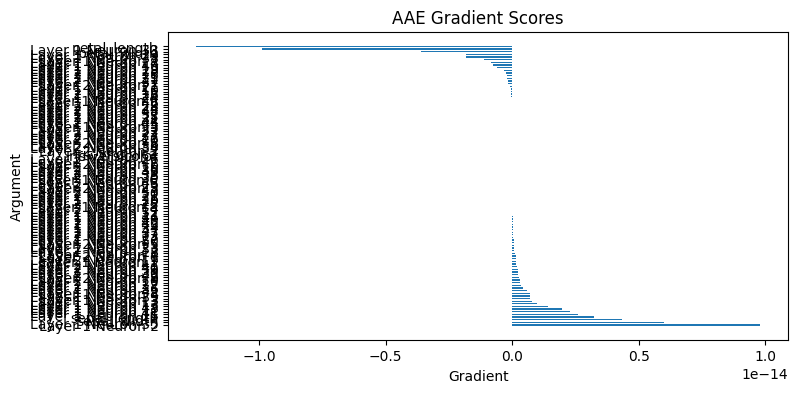

In [42]:
aae.create_gradient_plot();
# aae.create_shap_plot();
# aae.create_removal_plot();

In [43]:
AAE_gradients = aae.get_gradients()
max_abs_gradient_AAE = max(AAE_gradients, key=lambda arg: abs(AAE_gradients[arg]))
max_abs_gradient_AAE

'petal_length'

In [44]:
# rae = RAE(qbaf,
#           grad.SumAggregation(),
#           grad.MLPBasedInfluence(),
#           topic_arg,
#           shap_seed=2024,
#           shap_samples=200,
#           )

In [45]:
# rae.create_shap_plot(n_highest=15);
# rae.create_removal_plot(n_highest=15);

In [46]:
import sparx.sparx as sparx
import numpy as np

train_set = np.column_stack((X_train, y_train))

example_row = np.append(example, y_test[example_row_num])

# ONLY WORKING FOR CLASSIFIER WITH NON-CATEGORICAL FEATURES
s = sparx.LocalSpArX(classifier.coefs_, classifier.intercepts_, "logistic", 50, example_row, train_set, np.sqrt(X_test.shape[1]) * 0.75)

In [47]:
s_weights, s_biases = s.get_sparsified_mlp()

print("Sparsified shape: {}".format(s.get_sparsified_shape()))

Sparsified shape: [4, 25, 25, 3]


In [48]:
diff = np.abs(forward_pass(example, classifier.coefs_, classifier.intercepts_, logistic)[-1] - forward_pass(example, s_weights, s_biases, logistic)[-1])
print("Difference in outputs: {}".format(diff))

Difference in outputs: [1.00000000e+00 6.15138138e-06 1.00000000e+00]


In [49]:
qbaf_sparse = MLPToQBAF(s.get_sparsified_shape(), s_weights, s_biases, "logistic", input_features, output_names, example).get_qbaf()

In [50]:
# plot_qbaf(qbaf_sparse)

In [51]:
AAE_sparse = AAE(qbaf_sparse, grad.SumAggregation(), grad.MLPBasedInfluence(), topic_arg, h, shap_seed=2024, do_shap=False, do_removal=False)
# RAE_sparse = RAE(qbaf_sparse, grad.SumAggregation(), grad.MLPBasedInfluence(), topic_arg, shap_seed=2024, shap_samples=200)

Computing gradients:   0%|          | 0/56 [00:00<?, ?it/s]

Computing gradients: 100%|██████████| 56/56 [00:00<00:00, 633.65it/s]


In [52]:
AAE_gradients_sparse = AAE_sparse.get_gradients()
max_abs_gradient_sparse_AAE = max(AAE_gradients_sparse, key=lambda arg: abs(AAE_gradients_sparse[arg]))
max_abs_gradient_sparse_AAE

'sepal_length'

In [53]:
print(s.get_containing_neurons(1, 1))
print(s.get_containing_neurons(1, 2))
print(s.get_containing_neurons(1, 3))

[25]
[27]
[15 16]


In [54]:
print(s.get_containing_neurons(2, 1))
print(s.get_containing_neurons(2, 2))
print(s.get_containing_neurons(2, 3))

[ 8 16 26 29 35 36 38 45 47 49 50]
[ 2  6 17 20 21 22 25 27 34 44]
[12]


In [55]:
contains_full = []

for example_row_num in tqdm(range(len(X_test))):
    
    example = X_test[example_row_num]
    example_row = np.append(example, y_test[example_row_num])
    
    qbaf_full = MLPToQBAF(neurons_per_layer, classifier.coefs_, classifier.intercepts_, "logistic", input_features, output_names, example).get_qbaf()
    aae_full = AAE(qbaf_full, grad.SumAggregation(), grad.MLPBasedInfluence(), topic_arg, h, shap_seed=2024, verbose=False, do_shap=False, do_removal=False, do_gradient=True)
    full_gradients = aae_full.get_gradients()
    full_highest_score = max(full_gradients, key=lambda arg: abs(full_gradients[arg]))

    sp = sparx.LocalSpArX(classifier.coefs_, classifier.intercepts_, "logistic", 25, example_row, train_set, np.sqrt(X_test.shape[1]) * 0.75)
    sp_weights, sp_biases = sp.get_sparsified_mlp()
    qbaf_sparse = MLPToQBAF(sp.get_sparsified_shape(), sp_weights, sp_biases, "logistic", input_features, output_names, example).get_qbaf()
    aae_sparse = AAE(qbaf_sparse, grad.SumAggregation(), grad.MLPBasedInfluence(), topic_arg, h, shap_seed=2024, verbose=False, do_shap=False, do_removal=False, do_gradient=True)
    sparse_gradients = aae_sparse.get_gradients()
    sparse_highest_score = max(sparse_gradients, key=lambda arg: abs(sparse_gradients[arg]))
    
    if full_highest_score in input_features:
        layer_full = "input"
        neuron_full = full_highest_score
    else:
        full_split = full_highest_score.split(" ")
        layer_full = full_split[1]
        neuron_full = full_split[3]
    
    if sparse_highest_score in input_features:
        layer_sparse = "input"
        neuron_sparse = sparse_highest_score
    else:
        sparse_split = sparse_highest_score.split(" ")
        layer_sparse = sparse_split[1]
        neuron_sparse = sparse_split[3]

    if layer_full != layer_sparse:
        clustered_contains_original = False
    else:
        if layer_full == "input" or layer_sparse == "input":
            clustered_contains_original = neuron_full == neuron_sparse
        else:
            containing_neurons = s.get_containing_neurons(int(layer_sparse), int(neuron_sparse))
            clustered_contains_original = (int(neuron_full) in containing_neurons)

    contains_full.append(clustered_contains_original)

print(f"Clustered contains original: {round(sum(contains_full) / len(contains_full), 2) * 100}%")

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:53<00:00,  1.19s/it]

Clustered contains original: 40.0%


In [56]:
from sparx.sparx import ClusteringMethod
import importlib
importlib.reload(sparx)

input_features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
output_names = list(label_encoder.classes_)

LocalSpArX = sparx.LocalSpArX(classifier.coefs_, classifier.intercepts_, "logistic", 80, example_row, train_set, np.sqrt(X_test.shape[1]) * 0.75, input_features, output_names, topic_arg, ClusteringMethod.AAE_GRADIENT)

s_weights, s_biases = LocalSpArX.get_sparsified_mlp()

print("Sparsified shape: {}".format(LocalSpArX.get_sparsified_shape()))

diff = np.abs(forward_pass(example, classifier.coefs_, classifier.intercepts_, logistic)[-1] - forward_pass(example, s_weights, s_biases, logistic)[-1])
print("Difference in outputs: {}".format(diff))

Sparsified shape: [4, 1, 1, 3]
Difference in outputs: [1.10156329e-12 1.06111535e-07 7.78382772e-20]


In [57]:
from mlp_to_qbaf_converter.utils import forward_pass_dataset


def input_output_unfaithfulness(model, sparse_model, local_dataset, example_weights):
    weights_original, biases_original = model
    weights_sparse, biases_sparse = sparse_model

    original_output = forward_pass_dataset(
            local_dataset[:, :-1],
            weights_original,
            biases_original,
            logistic,
        )[-1]
    
    sparse_output = forward_pass_dataset(
            local_dataset[:, :-1],
            weights_sparse,
            biases_sparse,
            logistic,
        )[-1]
    
    diff = sparse_output - original_output
    diff = np.power(diff, 2)
    total = np.sum(diff, axis=1) 
    total = np.multiply(total, example_weights)
    total = np.sum(diff)

    return total / np.sum(example_weights)

In [58]:
from sparx.lime.lime import lime_tabular


classifier_test = classifier = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(50, 50,),
    max_iter=10000,
    random_state=2024,
    solver='lbfgs',
)
classifier_test.fit(X_train, y_train)

print(classifier_test.score(X_test, y_test))


model_original = (classifier_test.coefs_, classifier_test.intercepts_)

train_set = np.column_stack((X_train, y_train))


unfaith = 0

for example_row_num in tqdm(range(len(X_test))):
    
    example = X_test[example_row_num]
    example_row = np.append(example, y_test[example_row_num])

    sp = sparx.LocalSpArX(classifier_test.coefs_, classifier_test.intercepts_, "relu", 80, example_row, train_set, np.sqrt(X_test.shape[1]) * 0.75)
    sp_weights, sp_biases = sp.get_sparsified_mlp()


    # explainer = lime_tabular.LimeTabularExplainer(train_set, mode="classification",
    #                                                   random_state = 123)
    # explanation = explainer.explain_instance(
    #     example.reshape(-1, 1),
    #     classifier_test.predict_proba, 
    # )

    model_sparse = (sp_weights, sp_biases)
    local_dataset = sp.local_dataset
    example_weights = sp.example_weights

    unfaith += input_output_unfaithfulness(model_original, model_sparse, local_dataset, example_weights)

print(f"Unfaithfulness: {unfaith / len(X_test)}")



0.9333333333333333


100%|██████████| 45/45 [00:30<00:00,  1.48it/s]

Unfaithfulness: 1.0130408425492632
